In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-12-02 16:27:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   174MB/s    in 0.5s    

2021-12-02 16:27:15 (174 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  # Stop re-trained already pretrained model and images
  # Freeze (or lock) the already learned convolutions into your model
  layer.trainable = False

pre_trained_model.summary(line_length=150)

Model: "inception_v3"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_4 (InputLayer)                            [(None, 150, 150, 3)]            0                 []                                                
                                                                                                                                                      
 conv2d_282 (Conv2D)                             (None, 74, 74, 32)               864               ['input_4[0][0]']                                 
                                                                                                                                                      
 batch_normalization_282 (BatchNormalization)    (None, 74, 74, 32)     

In [7]:
# As per our model.summary() output our last layer output is `mixed10 (Concatenate) - (None, 3, 3, 2048)`
# but just for experiment We trying out with mixed7 (7 x 7), since its not much compressed and having more informations
# compare to `mixed10 (3, 3)`
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [12]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)              

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [13]:
# download cats-vs-dogs data
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 165MB/s]
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 28s - loss: 0.3399 - accuracy: 0.8675 - val_loss: 0.1342 - val_accuracy: 0.9490 - 28s/epoch - 282ms/step
Epoch 2/20
100/100 - 23s - loss: 0.2133 - accuracy: 0.9195 - val_loss: 0.0857 - val_accuracy: 0.9680 - 23s/epoch - 230ms/step
Epoch 3/20
100/100 - 22s - loss: 0.1844 - accuracy: 0.9300 - val_loss: 0.1454 - val_accuracy: 0.9500 - 22s/epoch - 218ms/step
Epoch 4/20
100/100 - 23s - loss: 0.1677 - accuracy: 0.9385 - val_loss: 0.1331 - val_accuracy: 0.9550 - 23s/epoch - 228ms/step
Epoch 5/20
100/100 - 22s - loss: 0.1487 - accuracy: 0.9415 - val_loss: 0.1221 - val_accuracy: 0.9640 - 22s/epoch - 219ms/step
Epoch 6/20
100/100 - 22s - loss: 0.1703 - accuracy: 0.9370 - val_loss: 0.1148 - val_accuracy: 0.9640 - 22s/epoch - 224ms/step
Epoch 7/20
100/100 - 22s - loss: 0.1704 - accuracy: 0.9365 - val_loss: 0.1196 - val_accuracy: 0.9550 - 22s/epoch - 218ms/step
Epoch 8/20
100/100 - 22s - loss: 0.1316 - accuracy: 0.9475 - val_loss: 0.1001 - val_accuracy: 0.9630 - 22s/epoch - 223

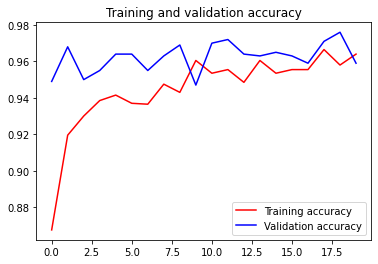

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()